In [ ]:
#Importation des donnees

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.ensemble import RandomForestClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
data = pd.read_csv("/content/drive/MyDrive/amazon_reviews.txt", delimiter='\t')
reader = csv.reader("/content/drive/MyDrive/amazon_reviews.txt", delimiter='\t')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [ ]:
print(reader)

In [ ]:
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    s=0
    if reviewLine[1]=="__label1__":
        s = 1 #"fake"
    else:
        s = 0 #"real"
    return (reviewLine[0], reviewLine[8], s)

In [ ]:
featureDict = {} # A global dictionary of features

def toFeatureVector(tokens):
    localDict = {}
    for token in tokens:
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] = +1

        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] = +1

    return localDict

In [ ]:
# load data from a file and append it to the rawData
def loadData():
    for index, row in data.iterrows():
        (Id, Text, Label) = parseReview(row)
        rawData.append((Id, Text, Label))
        preprocessedData.append((Id, preProcess(Text), Label))

def splitData(percentage):
    dataSamples = len(rawData)
    halfOfData = int(len(rawData)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    for (_, Text, Label) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(preProcess(Text)),Label))
    for (_, Text, Label) in rawData[trainingSamples:halfOfData] + rawData[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(preProcess(Text)),Label))

In [ ]:
# Input: a string of one review
def preProcess(text):
    # Should return a list of tokens
    return word_tokenize(text)

In [ ]:
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline = Pipeline([('rf', RandomForestClassifier())])
    return SklearnClassifier(pipeline).train(trainData)

def crossValidate(dataset, folds):
    shuffle(dataset)
    cv_results = []
    foldSize = int(len(dataset) / folds)
    for i in range(0, len(dataset), foldSize):
        classifier = trainClassifier(dataset[:i] + dataset[foldSize + i:])
        y_pred = predictLabels(dataset[i:i + foldSize], classifier)
        a = accuracy_score(list(map(lambda d: d[1], dataset[i:i + foldSize])), y_pred)
        (p, r, f, _) = precision_recall_fscore_support(list(map(lambda d: d[1], dataset[i:i + foldSize])), y_pred, average='macro')
        cv_results.append((a, p, r, f))
    cv_results = (np.mean(np.array(cv_results), axis=0))
    return cv_results

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [ ]:
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
preprocessedData = [] # the preprocessed reviews (just to see how your preprocessing is doing)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 1 #'fake'
realLabel = 0 #'real'

# references to the data files
reviewPath = 'content/drive/MyDrive/amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')
loadData(reviewPath)
# We split the raw dataset into a set of training data and a set of test data (80/20)
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)
# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", crossValidate(trainData, 10))

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 21000 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
16800
Features: 
52965
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.65815476 0.65831744 0.65818286 0.65804497]


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import string




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# TEXT PREPROCESSING AND FEATURE VECTORIZATION
table = str.maketrans({key: None for key in string.punctuation})

def preProcess(text):
    # Should return a list of tokens
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    stop_words = set(stopwords.words('english'))
    text = text.translate(table)
    for w in text.split(" "):
        if w not in stop_words:
            filtered_tokens.append(lemmatizer.lemmatize(w.lower()))
    return filtered_tokens

In [ ]:
# MAIN

# loading reviews
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
preprocessedData = [] # the preprocessed reviews (just to see how your preprocessing is doing)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')
loadData()
# We split the raw dataset into a set of training data and a set of test data (80/20)
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)
# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", crossValidate(trainData, 10))

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 21000 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
16800
Features: 
73061
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.67994048 0.68036394 0.68009833 0.67969581]


In [ ]:
# TEXT PREPROCESSING AND FEATURE VECTORIZATION
# Input: a string of one review
table = str.maketrans({key: None for key in string.punctuation})
def preProcess(text):
    # Should return a list of tokens
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(table)
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
        filtered_tokens = [' '.join(l) for l in nltk.bigrams(lemmatized_tokens)] + lemmatized_tokens
    return filtered_tokens

In [ ]:
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline = Pipeline([('rf', RandomForestClassifier())])
    return SklearnClassifier(pipeline).train(trainData)

In [ ]:
# MAIN

# loading reviews
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
preprocessedData = [] # the preprocessed reviews (just to see how your preprocessing is doing)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 1 #'fake'
realLabel = 0 #'real'

# references to the data files

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')
loadData()
# We split the raw dataset into a set of training data and a set of test data (80/20)
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)
# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", crossValidate(trainData, 10))

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 21000 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
16800
Features: 
542874
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.68494048 0.68917496 0.68502174 0.68310181]


In [ ]:
def loadData():
    for index, row in data.iterrows():
        (Id, Rating, verified_Purchase, product_Category, Text, Label) = parseReview(row)
        rawData.append((Id, Rating, verified_Purchase, product_Category, Text, Label))
        #preprocessedData.append((Id, preProcess(Text), Label))

In [ ]:
def splitData(percentage):
    dataSamples = len(rawData)
    halfOfData = int(len(rawData)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    for (_, Rating, verified_Purchase, product_Category, Text, Label) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(Rating, verified_Purchase, product_Category, preProcess(Text)),Label))
    for (_, Rating, verified_Purchase, product_Category, Text, Label) in rawData[trainingSamples:halfOfData] + rawData[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(Rating, verified_Purchase, product_Category, preProcess(Text)),Label))

In [ ]:
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    s=0
    if reviewLine[1]=="__label1__":
        s = 1 #"fake"
    else:
        s = 0 #"real"
    return (reviewLine[0], reviewLine[2], reviewLine[3], reviewLine[4], reviewLine[8], s)

In [ ]:
# Input: a string of one review
table = str.maketrans({key: None for key in string.punctuation})
def preProcess(text):
    # Should return a list of tokens
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(table)
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
        filtered_tokens = [' '.join(l) for l in nltk.bigrams(lemmatized_tokens)] + lemmatized_tokens
    return filtered_tokens

In [ ]:
featureDict = {} # A global dictionary of features

def toFeatureVector(Rating, verified_Purchase, product_Category, tokens):
    localDict = {}

#Rating

    #print(Rating)
    featureDict["R"] = 1
    localDict["R"] = Rating

#Verified_Purchase

    featureDict["VP"] = 1

    if verified_Purchase == "N":
        localDict["VP"] = 0
    else:
        localDict["VP"] = 1

#Product_Category


    if product_Category not in featureDict:
        featureDict[product_Category] = 1
    else:
        featureDict[product_Category] = +1

    if product_Category not in localDict:
        localDict[product_Category] = 1
    else:
        localDict[product_Category] = +1


#Text

    for token in tokens:
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] = +1

        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] = +1

    return localDict

In [ ]:
import matplotlib.pyplot as plt

def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

def crossValidate(dataset, folds):
    shuffle(dataset)
    cv_results = []
    foldSize = int(len(dataset)/folds)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    fscore_scores = []
    for i in range(0,len(dataset),foldSize):
        classifier = trainClassifier(dataset[:i]+dataset[foldSize+i:])
        y_pred = predictLabels(dataset[i:i+foldSize],classifier)
        a = accuracy_score(list(map(lambda d : d[1], dataset[i:i+foldSize])), y_pred)
        (p,r,f,_) = precision_recall_fscore_support(list(map(lambda d : d[1], dataset[i:i+foldSize])), y_pred, average ='macro')
        cv_results.append((a,p,r,f))
        accuracy_scores.append(a)
        precision_scores.append(p)
        recall_scores.append(r)
        fscore_scores.append(f)

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plotting Scores
    metrics = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    scores = [accuracy_scores, precision_scores, recall_scores, fscore_scores]
    colors = ['blue', 'orange', 'green', 'red']

    for metric, score, color in zip(metrics, scores, colors):
        plt.bar(metric, np.mean(score), color=color, label=metric)

    plt.title('Cross-Validation Metrics')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    cv_results = (np.mean(np.array(cv_results),axis=0))
    return cv_results

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 21000 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
16800
Features: 
512245
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...


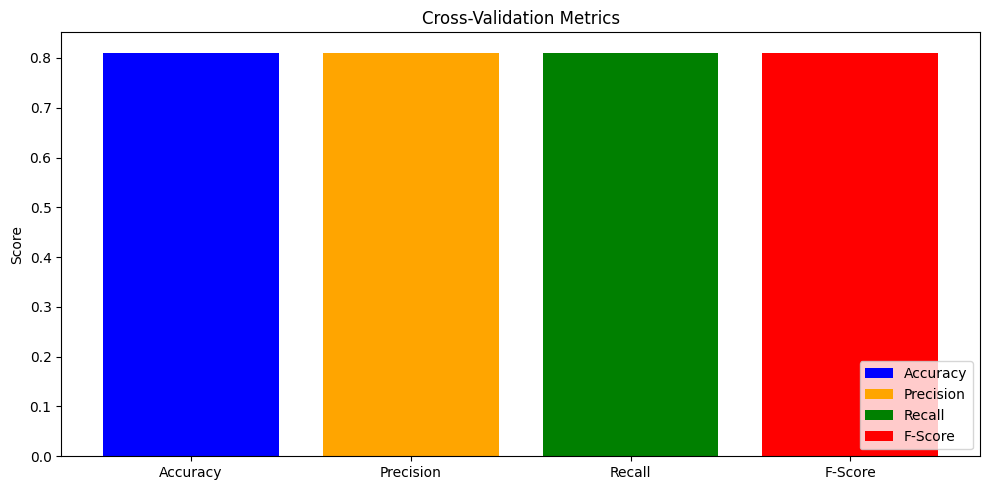

Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.81083333 0.81100242 0.81086785 0.81078092]


In [ ]:
# MAIN

# loading reviews
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
preprocessedData = [] # the preprocessed reviews (just to see how your preprocessing is doing)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 1 #'fake'
realLabel = 0 #'real'

# references to the data files

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')
loadData()
# We split the raw dataset into a set of training data and a set of test data (80/20)
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)
# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", crossValidate(trainData, 10))

In [ ]:
classifier = trainClassifier(trainData)
predictions = predictLabels(testData, classifier)
true_labels = list(map(lambda d: d[1], testData))
a = accuracy_score(true_labels, predictions)
p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print("accuracy: ", a)
print("Precision: ", p)
print("Recall: ", a)
print("f1-score: ", f1)

Training Classifier...
accuracy:  0.7878571428571428
Precision:  0.790157944023711
Recall:  0.7878571428571428
f1-score:  0.7874357619705412
